In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
from sklearn.metrics import roc_curve, auc

from automations import RM1

# 🐀 collect metadata for the rat
---

In [10]:
SAVE_DIRECTORY_DW327 = Path(fr'D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327')
DATA_DIRECTORY = Path(fr'D:\SynologyDrive\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')
PROBE_DIRECTORY = Path(r'D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32.prb')
DW327 = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, "DW327")
DW322 = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, "DW322")
DW323 = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, "DW323")

Reading DRGS_10_241125_150417...
Error reading stream 2 for DRGS_10_241125_150417. continuing...
Reading DRGS_11_241125_151101...
Error reading stream 2 for DRGS_11_241125_151101. continuing...
Reading DRGS_12_241125_151746...
Error reading stream 2 for DRGS_12_241125_151746. continuing...
Reading DRGS_1_241125_134024...
Error reading stream 2 for DRGS_1_241125_134024. continuing...
Reading DRGS_2_241125_140406...
Error reading stream 2 for DRGS_2_241125_140406. continuing...
Reading DRGS_3_241125_141057...
Error reading stream 2 for DRGS_3_241125_141057. continuing...
Reading DRGS_4_241125_141635...
Error reading stream 2 for DRGS_4_241125_141635. continuing...
Reading DRGS_5_241125_142348...
Error reading stream 2 for DRGS_5_241125_142348. continuing...
Reading DRGS_6_241125_143021...
Error reading stream 2 for DRGS_6_241125_143021. continuing...
Reading DRGS_7_241125_143654...
Error reading stream 2 for DRGS_7_241125_143654. continuing...
Reading DRGS_8_241125_144608...
Error readin

In [11]:
DW323.qst_trial_notes

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.,NaN,NaN
Trial Number,,,,,,,,,,,
1,1,VF,70,300,5,180,vf,NaN,30,pos 1,pad just prximal from toe
2,2,VF,70,300,20,180,vf,NaN,30,pos 1,NaN
3,3,VF,70,300,100,180,vf,NaN,30,pos 1,NaN
4,4,VF,70,300,100,180,vf,NaN,30,pos 2,toes
5,5,VF,70,300,5,180,vf,NaN,30,pos 2,NaN
6,6,VF,70,300,20,180,vf,NaN,30,pos 2,NaN


# 📊 recreating the plotting methods that previously required passing the rat |class into it
---

In [ ]:

def plot_pre_post_stim_from_firing_div_von_frey(neuron_firing_div_von_frey,
                                                rat_qst_notes=None):
    """
    Plots pre- vs. post-stim data (firing_rate / voltage) for each trial.
    Each trial's clusters are displayed as points in a scatter plot, 
    with x = pre-stim ratio, y = post-stim ratio.
    
    If a 'rat_qst_notes' DataFrame is provided, looks up each trial's 
    frequency (Hz) to color-code points. Otherwise, all points appear in one color.

    Parameters
    ----------
    neuron_firing_div_von_frey : dict
        Maps trial_name -> DataFrame, where each DataFrame has:
            - Index = [pre-stim, post-stim]
            - Columns = cluster IDs
            - Values = ratio (firing / voltage)
    rat_qst_notes : pd.DataFrame, optional
        A DataFrame (e.g., DW327.qst_trial_notes) with a numeric index for each 
        trial number and at least one column named 'Freq. (Hz)' 
        to retrieve the frequency for color-coding.

    Returns
    -------
    None
    """

    all_points = []  # Will hold tuples of (pre_stim_value, post_stim_value, freq_hz)

    # Go through each trial in the dictionary
    for trial_name, ratio_df in neuron_firing_div_von_frey.items():
        
        # Attempt to parse out the trial number from `trial_name` 
        # (adapt this logic to match how your trial names are structured)
        trial_parts = trial_name.split('_')
        freq_hz = None
        if rat_qst_notes is not None and len(trial_parts) > 1:
            try:
                trial_num = int(trial_parts[1])
                # If 'Freq. (Hz)' is in rat_qst_notes, we fetch frequency
                if trial_num in rat_qst_notes.index and 'Freq. (Hz)' in rat_qst_notes.columns:
                    freq_hz = rat_qst_notes.loc[trial_num, 'Freq. (Hz)']
            except ValueError:
                pass  # If we can't parse it, freq_hz remains None

        # Check that ratio_df has the expected rows
        if not {'pre-stim', 'post-stim'}.issubset(ratio_df.index):
            print(f"Trial '{trial_name}' missing 'pre-stim' or 'post-stim' rows. Skipping.")
            continue

        # For each cluster (column) in the DataFrame, extract the pre/post values
        for cluster_col in ratio_df.columns:
            pre_val = ratio_df.loc['pre-stim', cluster_col]
            post_val = ratio_df.loc['post-stim', cluster_col]

            # Skip if either value is NaN
            if pd.isna(pre_val) or pd.isna(post_val):
                continue

            # Store the point with freq_hz (None if not found)
            all_points.append((pre_val, post_val, freq_hz))

    # If we have no points to plot, just return
    if not all_points:
        print("No data points to plot.")
        return

    # Create a DataFrame for plotting
    all_points_df = pd.DataFrame(all_points, columns=['pre_stim', 'post_stim', 'freq_hz'])

    # If we have frequencies, color by freq_hz; otherwise single color
    # Convert freq_hz to numeric to handle anything that can be cast (or stays None if missing)
    all_points_df['freq_hz'] = pd.to_numeric(all_points_df['freq_hz'], errors='coerce')
    unique_freqs = all_points_df['freq_hz'].dropna().unique()

    # Plot
    plt.figure(figsize=(8, 6))
    if len(unique_freqs) == 0:
        # No valid frequency info -> single color scatter
        plt.scatter(all_points_df['pre_stim'], all_points_df['post_stim'], alpha=0.7)
        plt.title("Pre vs. Post Stim Ratio (All Trials)")
    else:
        # We have at least one valid frequency -> color-code by freq
        cmap = plt.get_cmap('tab10')
        freq_to_color = {freq: cmap(i % 10) for i, freq in enumerate(np.sort(unique_freqs))}

        for freq in freq_to_color:
            freq_data = all_points_df[all_points_df['freq_hz'] == freq]
            plt.scatter(freq_data['pre_stim'], freq_data['post_stim'],
                        color=freq_to_color[freq], alpha=0.7, label=f'{freq} Hz')

        plt.legend(title='Stim Frequency')
        plt.title("Pre vs. Post Stim Ratio (All Trials, Colored by Freq)")

    # Optional diagonal line: y = x
    combined_vals = pd.concat([all_points_df['pre_stim'], all_points_df['post_stim']])
    min_val, max_val = combined_vals.min(), combined_vals.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')

    plt.xlabel('Pre-Stim Ratio (firing / voltage)')
    plt.ylabel('Post-Stim Ratio (firing / voltage)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_pre_post_stim_from_firing_div_von_frey_with_trend(
    neuron_firing_div_von_frey,
    rat_qst_notes=None
):
    """
    Plots pre- vs. post-stim data (firing_rate / voltage) for each trial.
    Each trial's clusters are displayed as points in a scatter plot, 
    with x = pre-stim ratio, y = post-stim ratio.
    
    If a 'rat_qst_notes' DataFrame is provided, looks up each trial's 
    frequency (Hz) to color-code points. Otherwise, all points appear 
    in one color. For each frequency group, a linear trend line is 
    added (intercept fixed at 0).

    Parameters
    ----------
    neuron_firing_div_von_frey : dict
        Maps trial_name -> DataFrame, where each DataFrame has:
            - Index = [pre-stim, post-stim]
            - Columns = cluster IDs
            - Values = ratio (firing / voltage)
    rat_qst_notes : pd.DataFrame, optional
        A DataFrame with a numeric index for each trial number and 
        at least one column named 'Freq. (Hz)' for color-coding.

    Returns
    -------
    None
    """

    all_points = []  # Will hold tuples of (pre_stim_value, post_stim_value, freq_hz)

    for trial_name, ratio_df in neuron_firing_div_von_frey.items():
        # Attempt to parse out the trial number from `trial_name` 
        trial_parts = trial_name.split('_')
        freq_hz = None

        if rat_qst_notes is not None and len(trial_parts) > 1:
            try:
                trial_num = int(trial_parts[1])
                if trial_num in rat_qst_notes.index and 'Freq. (Hz)' in rat_qst_notes.columns:
                    freq_hz = rat_qst_notes.loc[trial_num, 'Freq. (Hz)']
            except ValueError:
                pass  # If we can't parse it, freq_hz remains None

        # Check that ratio_df has pre-stim and post-stim rows
        if not {'pre-stim', 'post-stim'}.issubset(ratio_df.index):
            continue

        # For each cluster in the DataFrame, extract pre and post values
        for cluster_col in ratio_df.columns:
            pre_val = ratio_df.loc['pre-stim', cluster_col]
            post_val = ratio_df.loc['post-stim', cluster_col]

            if pd.isna(pre_val) or pd.isna(post_val):
                continue

            all_points.append((pre_val, post_val, freq_hz))

    if not all_points:
        return

    # Create a DataFrame for plotting
    all_points_df = pd.DataFrame(all_points, columns=['pre_stim', 'post_stim', 'freq_hz'])

    # Convert freq_hz to numeric if present
    all_points_df['freq_hz'] = pd.to_numeric(all_points_df['freq_hz'], errors='coerce')
    unique_freqs = all_points_df['freq_hz'].dropna().unique()

    plt.figure(figsize=(8, 6))

    # If no frequency info is available, do a single scatter and skip color grouping
    if len(unique_freqs) == 0:
        plt.scatter(all_points_df['pre_stim'], all_points_df['post_stim'], alpha=0.7)
    else:
        cmap = plt.get_cmap('tab10')
        freq_to_color = {freq: cmap(i % 10) for i, freq in enumerate(np.sort(unique_freqs))}

        for freq in freq_to_color:
            freq_data = all_points_df[all_points_df['freq_hz'] == freq]
            color = freq_to_color[freq]

            # Scatter plot for this group
            plt.scatter(freq_data['pre_stim'], freq_data['post_stim'], color=color,
                        alpha=0.7, label=f'{freq} Hz')

            # Linear trend with intercept = 0
            if len(freq_data) > 1:
                x = freq_data['pre_stim'].values
                y = freq_data['post_stim'].values
                slope = np.sum(x * y) / np.sum(x**2)
                xvals = np.linspace(x.min(), x.max(), 100)
                plt.plot(xvals, slope * xvals, color=color, linewidth=2, alpha=0.7)

        plt.legend(title='Stim Frequency')

    # Optional diagonal line y = x
    combined_vals = pd.concat([all_points_df['pre_stim'], all_points_df['post_stim']])
    min_val, max_val = combined_vals.min(), combined_vals.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')

    plt.xlabel('Pre-Stim Ratio (firing / voltage)')
    plt.ylabel('Post-Stim Ratio (firing / voltage)')
    plt.title("Pre vs. Post Stim Ratio (All Trials)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



def plot_pre_post_stim_from_firing_div_von_frey_with_trend(
    neuron_firing_div_von_frey,
    rat_qst_notes=None
):
    """
    Plots pre- vs. post-stim data (firing_rate / voltage) for each trial.
    Each trial's clusters are displayed as points in a scatter plot, 
    with x = pre-stim ratio, y = post-stim ratio.
    
    If a 'rat_qst_notes' DataFrame is provided, looks up each trial's 
    frequency (Hz) to color-code points. Otherwise, all points appear 
    in one color. For each frequency group, a linear trend line is 
    added (intercept fixed at 0).

    Parameters
    ----------
    neuron_firing_div_von_frey : dict
        Maps trial_name -> DataFrame, where each DataFrame has:
            - Index = [pre-stim, post-stim]
            - Columns = cluster IDs
            - Values = ratio (firing / voltage)
    rat_qst_notes : pd.DataFrame, optional
        A DataFrame with a numeric index for each trial number and 
        at least one column named 'Freq. (Hz)' for color-coding.

    Returns
    -------
    None
    """

    all_points = []  # Will hold tuples of (pre_stim_value, post_stim_value, freq_hz)

    for trial_name, ratio_df in neuron_firing_div_von_frey.items():
        # Attempt to parse out the trial number from `trial_name` 
        trial_parts = trial_name.split('_')
        freq_hz = None

        if rat_qst_notes is not None and len(trial_parts) > 1:
            try:
                trial_num = int(trial_parts[1])
                if trial_num in rat_qst_notes.index and 'Freq. (Hz)' in rat_qst_notes.columns:
                    freq_hz = rat_qst_notes.loc[trial_num, 'Freq. (Hz)']
            except ValueError:
                pass  # If we can't parse it, freq_hz remains None

        # Check that ratio_df has pre-stim and post-stim rows
        if not {'pre-stim', 'post-stim'}.issubset(ratio_df.index):
            continue

        # For each cluster in the DataFrame, extract pre and post values
        for cluster_col in ratio_df.columns:
            pre_val = ratio_df.loc['pre-stim', cluster_col]
            post_val = ratio_df.loc['post-stim', cluster_col]

            if pd.isna(pre_val) or pd.isna(post_val):
                continue

            all_points.append((pre_val, post_val, freq_hz))

    if not all_points:
        return

    # Create a DataFrame for plotting
    all_points_df = pd.DataFrame(all_points, columns=['pre_stim', 'post_stim', 'freq_hz'])

    # Convert freq_hz to numeric if present
    all_points_df['freq_hz'] = pd.to_numeric(all_points_df['freq_hz'], errors='coerce')
    unique_freqs = all_points_df['freq_hz'].dropna().unique()

    plt.figure(figsize=(8, 6))

    # If no frequency info is available, do a single scatter and skip color grouping
    if len(unique_freqs) == 0:
        plt.scatter(all_points_df['pre_stim'], all_points_df['post_stim'], alpha=0.7)
    else:
        cmap = plt.get_cmap('tab10')
        freq_to_color = {freq: cmap(i % 10) for i, freq in enumerate(np.sort(unique_freqs))}

        for freq in freq_to_color:
            freq_data = all_points_df[all_points_df['freq_hz'] == freq]
            color = freq_to_color[freq]

            # Scatter plot for this group
            plt.scatter(freq_data['pre_stim'], freq_data['post_stim'], color=color,
                        alpha=0.7, label=f'{freq} Hz')

            # Linear trend with intercept = 0
            if len(freq_data) > 1:
                x = freq_data['pre_stim'].values
                y = freq_data['post_stim'].values
                slope = np.sum(x * y) / np.sum(x**2)
                xvals = np.linspace(x.min(), x.max(), 100)
                plt.plot(xvals, slope * xvals, color=color, linewidth=2, alpha=0.7)

        plt.legend(title='Stim Frequency')

    # Optional diagonal line y = x
    combined_vals = pd.concat([all_points_df['pre_stim'], all_points_df['post_stim']])
    min_val, max_val = combined_vals.min(), combined_vals.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')

    plt.xlabel('Pre-Stim Ratio (firing / voltage)')
    plt.ylabel('Post-Stim Ratio (firing / voltage)')
    plt.title("Pre vs. Post Stim Ratio (All Trials)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



# 🔽 filter units with total unresponsiveness greater than a set threshold

idea:

most of the units have some portion of zero firing rate during stimulus. I want to remove all units that have zero firing rates above some stimulus


## Steps

1) filter out any units where the absolute value of the correlation coefficient is below some threshold (say, 0.2 for the example)

---

### define new threshold: the unit must have a non-zero firing rate for more than this percent of time windows:

In [ ]:
# Define the threshold for zero proportion
zero_threshold = 0.20  # Example: remove columns where more than this % of values are zero

## analysis: DW327

In [ ]:

# Define the folder path
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\tables"

# Dictionary to store the merged data
voltage_data = {}
cluster_firing_data = {}
groups = {}
cluster_firing_data_filtered = {}
cluster_unresponsiveness_percentage = {} # create a dataframe for the number of rows with 0 in the firing rate
neuron_firing_div_von_frey = {}




# Iterate through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith("_average_vf_voltage_windowed.xlsx"):
        # Extract trial name (assuming consistent naming convention)
        trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]

        # Construct file paths
        voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
        firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")

        # Ensure both files exist before processing
        if os.path.exists(voltage_file) and os.path.exists(firing_file):
            voltage_windows = pd.read_excel(voltage_file)
            cluster_firing = pd.read_excel(firing_file).iloc[:-2, :]
            group = cluster_firing["group"]

            # Calculate the proportion of zero values in each column (excluding specific columns)
            zero_proportions = ((cluster_firing == 0).sum() / len(cluster_firing)).drop(["group", "avg_voltage"], errors='ignore')
            # zero_proportions = zero_proportions.drop(["group", "avg_voltage"], errors='ignore')

            # Filter columns based on the threshold
            columns_to_keep = zero_proportions[zero_proportions <= zero_threshold].index
            df_filtered = cluster_firing[columns_to_keep].drop(columns = ["Unnamed: 0"])

            # divide the firing rate of the filtered cluster by the average voltage
            cluster_firing_div_voltage_windows = df_filtered.div(voltage_windows["avg_voltage"].values, axis=0)
            cluster_firing_div_voltage_windows_with_groups = cluster_firing_div_voltage_windows.copy()
            cluster_firing_div_voltage_windows_with_groups["group"] = group

            # Calculate the mean for each cluster grouped by "pre-stim" and "post-stim"
            # pre_post_stim_comparison = cluster_firing_div_voltage_windows_with_groups.groupby("group").mean()

            ## store the results of each metric in a dictionary:
            # store the firing rate of clusters, voltage, and group of each time window
            voltage_data[trial_name] = voltage_windows
            cluster_firing_data[trial_name] = cluster_firing.drop(columns = ["Unnamed: 0"])
            groups[trial_name] = group
            # Store the filtered data and zero proportions
            cluster_firing_data_filtered[trial_name] = df_filtered
            # store the percentage of stimulus windows 
            cluster_unresponsiveness_percentage[trial_name] = zero_proportions
            # store the cluster firing divided by von frey

            ## finally, calculate the average firing rate, divided by average von frey voltage, pre & post stim
            neuron_firing_div_von_frey[trial_name] = cluster_firing_div_voltage_windows_with_groups.groupby("group").mean()


In [ ]:
neuron_firing_div_von_frey["VF_1_241125_153746"]

In [ ]:
neuron_firing_div_von_frey["VF_1_241125_153746"]

## plots - DW327

In [ ]:
plot_pre_post_stim_from_firing_div_von_frey_with_trend(neuron_firing_div_von_frey,
                                                rat_qst_notes=DW327.qst_trial_notes)

## analysis - DW323

In [ ]:

# Define the folder path
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW323\tables"

# Dictionary to store the merged data
voltage_data = {}
cluster_firing_data = {}
groups = {}
cluster_firing_data_filtered = {}
cluster_unresponsiveness_percentage = {} # create a dataframe for the number of rows with 0 in the firing rate
neuron_firing_div_von_frey = {}




# Iterate through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith("_average_vf_voltage_windowed.xlsx"):
        # Extract trial name (assuming consistent naming convention)
        trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]

        # Construct file paths
        voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
        firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")

        # Ensure both files exist before processing
        if os.path.exists(voltage_file) and os.path.exists(firing_file):
            voltage_windows = pd.read_excel(voltage_file)
            cluster_firing = pd.read_excel(firing_file).iloc[:-2, :]
            group = cluster_firing["group"]

            # Calculate the proportion of zero values in each column (excluding specific columns)
            zero_proportions = ((cluster_firing == 0).sum() / len(cluster_firing)).drop(["group", "avg_voltage"], errors='ignore')
            # zero_proportions = zero_proportions.drop(["group", "avg_voltage"], errors='ignore')

            # Filter columns based on the threshold
            columns_to_keep = zero_proportions[zero_proportions <= zero_threshold].index
            df_filtered = cluster_firing[columns_to_keep]#.drop(columns = ["Unnamed: 0"])

            # divide the firing rate of the filtered cluster by the average voltage
            cluster_firing_div_voltage_windows = df_filtered.div(voltage_windows["avg_voltage"].values, axis=0)
            cluster_firing_div_voltage_windows_with_groups = cluster_firing_div_voltage_windows.copy()
            cluster_firing_div_voltage_windows_with_groups["group"] = group

            # Calculate the mean for each cluster grouped by "pre-stim" and "post-stim"
            # pre_post_stim_comparison = cluster_firing_div_voltage_windows_with_groups.groupby("group").mean()

            ## store the results of each metric in a dictionary:
            # store the firing rate of clusters, voltage, and group of each time window
            voltage_data[trial_name] = voltage_windows
            cluster_firing_data[trial_name] = cluster_firing.drop(columns = ["Unnamed: 0"])
            groups[trial_name] = group
            # Store the filtered data and zero proportions
            cluster_firing_data_filtered[trial_name] = df_filtered
            # store the percentage of stimulus windows 
            cluster_unresponsiveness_percentage[trial_name] = zero_proportions
            # store the cluster firing divided by von frey

            ## finally, calculate the average firing rate, divided by average von frey voltage, pre & post stim
            neuron_firing_div_von_frey[trial_name] = cluster_firing_div_voltage_windows_with_groups.groupby("group").mean()


## plot - DW323

In [ ]:
plot_pre_post_stim_from_firing_div_von_frey_with_trend(neuron_firing_div_von_frey,
                                                rat_qst_notes=DW323.qst_trial_notes)

## analysis - DW322

In [ ]:

# Define the folder path
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW322\tables"

# Dictionary to store the merged data
voltage_data = {}
cluster_firing_data = {}
groups = {}
cluster_firing_data_filtered = {}
cluster_unresponsiveness_percentage = {} # create a dataframe for the number of rows with 0 in the firing rate
neuron_firing_div_von_frey = {}

# Iterate through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith("_average_vf_voltage_windowed.xlsx"):
        # Extract trial name (assuming consistent naming convention)
        trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]

        # Construct file paths
        voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
        firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")

        # Ensure both files exist before processing
        if os.path.exists(voltage_file) and os.path.exists(firing_file):
            voltage_windows = pd.read_excel(voltage_file)
            cluster_firing = pd.read_excel(firing_file).iloc[:-2, :]
            group = cluster_firing["group"]

            # Calculate the proportion of zero values in each column (excluding specific columns)
            zero_proportions = ((cluster_firing == 0).sum() / len(cluster_firing)).drop(["group", "avg_voltage"], errors='ignore')
            # zero_proportions = zero_proportions.drop(["group", "avg_voltage"], errors='ignore')

            # Filter columns based on the threshold
            columns_to_keep = zero_proportions[zero_proportions <= zero_threshold].index
            df_filtered = cluster_firing[columns_to_keep].drop(columns = ["Unnamed: 0"])

            # divide the firing rate of the filtered cluster by the average voltage
            cluster_firing_div_voltage_windows = df_filtered.div(voltage_windows["avg_voltage"].values, axis=0)
            cluster_firing_div_voltage_windows_with_groups = cluster_firing_div_voltage_windows.copy()
            cluster_firing_div_voltage_windows_with_groups["group"] = group

            # Calculate the mean for each cluster grouped by "pre-stim" and "post-stim"
            # pre_post_stim_comparison = cluster_firing_div_voltage_windows_with_groups.groupby("group").mean()

            ## store the results of each metric in a dictionary:
            # store the firing rate of clusters, voltage, and group of each time window
            voltage_data[trial_name] = voltage_windows
            cluster_firing_data[trial_name] = cluster_firing.drop(columns = ["Unnamed: 0"])
            groups[trial_name] = group
            # Store the filtered data and zero proportions
            cluster_firing_data_filtered[trial_name] = df_filtered
            # store the percentage of stimulus windows 
            cluster_unresponsiveness_percentage[trial_name] = zero_proportions
            # store the cluster firing divided by von frey

            ## finally, calculate the average firing rate, divided by average von frey voltage, pre & post stim
            neuron_firing_div_von_frey[trial_name] = cluster_firing_div_voltage_windows_with_groups.groupby("group").mean()


## plots - DW322

In [ ]:
plot_pre_post_stim_from_firing_div_von_frey_with_trend(neuron_firing_div_von_frey,
                                                rat_qst_notes=DW322.qst_trial_notes)

# ⏬ Method 2: Filter Intra-Stimulus Inactivity

I think I may need to filter based on units that don’t show up in the second half of the experiment at all

- after another review, it just seems like the best action would be, for every cluster, to remove the row if the cluster firing rate is zero (this tells me we did not activate it)

## Steps

1) first, filter out any units where the absolute value of the correlation coefficient is below some threshold (say, 0.2 for the example)

2) then, for every unit, filter out any zero rows. if a unit has zero remaining columns in the pre-stim or the post-stim groups, remove that unit entirely.
---


## trial run - VF_1_241125_153746

In [ ]:
vf_raw = pd.read_excel(r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\tables\VF_1_241125_153746_average_vf_voltage_windowed.xlsx")
vf_raw.tail(5)

In [ ]:
# Pseudocode: your actual data loading may differ
df_raw = pd.read_excel(r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\tables\VF_1_241125_153746_cluster_firing_rates_windowed.xlsx").iloc[:,1:]

# Example: show the bottom rows to verify correlation row location
df_raw.tail(5)

In [59]:
def filter_by_correlation(df, correlation_threshold=0.2):
    """
    1) Extract the correlation row.
    2) Filter columns by the absolute value of their correlation.
    3) Drop the correlation row (and any other non-data rows).
    4) Keep only the surviving columns plus the 'group' column.
    """

    # Suppose the correlation row is the second-to-last row in df.
    # Adjust the index if necessary.
    correlation_row_idx = df.index[-2]  # example if 'correlation' is second last
    correlation_series = df.loc[correlation_row_idx]

    # Drop any non-neuron columns from the correlation series (like 'group')
    # This prevents KeyError if 'group' doesn't exist in that row.
    if 'group' in correlation_series.index:
        correlation_series = correlation_series.drop('group', errors='ignore')

    # Identify columns (neurons) that meet the threshold
    # e.g., abs(correlation) >= 0.2
    columns_to_keep = correlation_series[correlation_series.abs() >= correlation_threshold].index.tolist()

    # Remove the bottom rows used for correlation info
    # For instance, remove the last 2 rows (correlation + is_correlated).
    # Adjust if you only have 1 such row at the bottom.
    df_filtered = df.iloc[:-2].copy()

    # Keep only the surviving neuron columns plus the group column
    columns_final = [col for col in columns_to_keep if col in df_filtered.columns]
    if 'group' in df_filtered.columns:
        columns_final.append('group')

    df_filtered = df_filtered[columns_final]

    return df_filtered


In [60]:
def remove_zeros_and_check_pre_post(df):
    """
    For each neuron (column):
      - Remove rows where firing == 0 for that neuron.
      - If the neuron no longer has any pre-stim OR post-stim rows, remove the neuron entirely.
    """
    # We'll collect neurons to drop after we check each one
    neurons_to_drop = []

    # Identify neuron columns (everything except 'group')
    neuron_cols = [c for c in df.columns if c != 'group']

    for col in neuron_cols:
        # Create a temporary subset that excludes zero rows for this neuron
        temp_subset = df[df[col] != 0].copy()

        # Check how many pre-stim and post-stim rows remain
        num_pre = (temp_subset['group'] == 'pre-stim').sum()
        num_post = (temp_subset['group'] == 'post-stim').sum()

        # If we have zero rows in either category, mark this neuron for removal
        if num_pre == 0 or num_post == 0:
            neurons_to_drop.append(col)

    # Drop those neurons entirely
    df_filtered = df.drop(columns=neurons_to_drop, errors='ignore')

    # Optionally, also remove the zero rows from the columns that remain.
    # But that might remove different rows for different neurons. Typically,
    # you'd keep all rows in the final DataFrame if you want to keep time alignment.
    #
    # If you want to remove zero rows for all remaining neurons, you'd do something like:
    #
    # for col in df_filtered.columns:
    #     if col != 'group':
    #         df_filtered = df_filtered[df_filtered[col] != 0]
    #
    # But be aware that removing zero rows in one neuron might also discard
    # data from other neurons at the same row/time point.

    return df_filtered


In [ ]:
# Example usage

# df_raw is your DataFrame with time windows + correlation info
correlation_threshold = 0.2

# Step 1: Filter columns by correlation
df_step1 = filter_by_correlation(df_raw, correlation_threshold=correlation_threshold)

# Step 2: Remove zeros for each neuron and discard neurons with no pre or post data after zero-removal
df_final = remove_zeros_and_check_pre_post(df_step1)

# df_final now contains only the neurons that pass:
#  (a) correlation threshold
#  (b) has at least 1 non-zero row for pre-stim and post-stim
df_final.tail(5)


In [ ]:
# Convert your DataFrame to an object type so it can hold mixed types
df_final = df_final.astype(object)
# Replace all 0 with the string "NR"
df_final[df_final == 0] = "NR"
df_final.head(5)


In [ ]:
neuron_df = df_final
voltage_df = vf_raw

In [ ]:
neuron_columns = neuron_df.columns[:-1]  # Exclude the 'group' column
neuron_columns

In [ ]:
nr_mask_all = neuron_df[neuron_columns].apply(lambda row: all(cell == 'NR' for cell in row), axis=1)
nr_mask_all

In [ ]:
nr_mask_any = neuron_df[neuron_columns].apply(lambda row: any(cell == 'NR' for cell in row), axis=1)
nr_mask_any

In [ ]:
# Using the fully non-responsive mask
neuron_df_clean = neuron_df.copy()
neuron_df_clean.loc[nr_mask_any, neuron_columns] = np.nan

# Similarly, handle the voltage dataframe
voltage_df_clean = voltage_df.copy()
voltage_df_clean.loc[nr_mask_any, 'avg_voltage'] = np.nan


In [ ]:
neuron_df_clean

In [ ]:
voltage_df_clean

In [ ]:
neuron_df_clean[neuron_columns] = neuron_df_clean[neuron_columns].apply(pd.to_numeric, errors='coerce')
neuron_df_clean

In [ ]:
# Create a new dataframe for normalized firing rates
neuron_normalized = neuron_df_clean[neuron_columns].div(voltage_df_clean['avg_voltage'], axis=0)

# Optionally, rename the columns to indicate normalization
neuron_normalized = neuron_normalized.add_prefix('Unit_')
neuron_normalized = neuron_normalized.add_suffix('_firing_Rate_per_microVolt')
neuron_normalized


In [ ]:
neuron_normalized["group"] = neuron_df_clean["group"]
neuron_normalized.groupby("group").mean()

## analysis - DW327:

In [ ]:

# Define the folder path
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\tables"

# Initialize dictionaries to store results
voltage_data = {}
cluster_firing_data = {}
groups = {}
cluster_firing_data_filtered = {}
cluster_unresponsiveness_percentage = {}
neuron_firing_div_von_frey = {}
neuron_normalized_dict = {}  # To store normalized firing rates

# Define correlation threshold
correlation_threshold = 0.2

# Define zero threshold if needed (from old method)
zero_threshold = 0.5  # Example value, adjust as necessary

# Define processing functions
def filter_by_correlation(df, correlation_threshold=0.2):
    """
    1) Extract the correlation row.
    2) Filter columns by the absolute value of their correlation.
    3) Drop the correlation row (and any other non-data rows).
    4) Keep only the surviving columns plus the 'group' column.
    """
    # Suppose the correlation row is the second-to-last row in df.
    # Adjust the index if necessary.
    correlation_row_idx = df.index[-2]  # example if 'correlation' is second last
    correlation_series = df.loc[correlation_row_idx]

    # Drop any non-neuron columns from the correlation series (like 'group')
    # This prevents KeyError if 'group' doesn't exist in that row.
    if 'group' in correlation_series.index:
        correlation_series = correlation_series.drop('group', errors='ignore')

    # Identify columns (neurons) that meet the threshold
    # e.g., abs(correlation) >= 0.2
    columns_to_keep = correlation_series[correlation_series.abs() >= correlation_threshold].index.tolist()

    # Remove the bottom rows used for correlation info
    # For instance, remove the last 2 rows (correlation + is_correlated).
    # Adjust if you only have 1 such row at the bottom.
    df_filtered = df.iloc[:-2].copy()

    # Keep only the surviving neuron columns plus the group column
    columns_final = [col for col in columns_to_keep if col in df_filtered.columns]
    if 'group' in df_filtered.columns:
        columns_final.append('group')

    df_filtered = df_filtered[columns_final]

    return df_filtered

def remove_zeros_and_check_pre_post(df):
    """
    For each neuron (column):
      - Remove rows where firing == 0 for that neuron.
      - If the neuron no longer has any pre-stim OR post-stim rows, remove the neuron entirely.
    """
    # We'll collect neurons to drop after we check each one
    neurons_to_drop = []

    # Identify neuron columns (everything except 'group')
    neuron_cols = [c for c in df.columns if c != 'group']

    for col in neuron_cols:
        # Create a temporary subset that excludes zero rows for this neuron
        temp_subset = df[df[col] != 0].copy()

        # Check how many pre-stim and post-stim rows remain
        num_pre = (temp_subset['group'] == 'pre-stim').sum()
        num_post = (temp_subset['group'] == 'post-stim').sum()

        # If we have zero rows in either category, mark this neuron for removal
        if num_pre == 0 or num_post == 0:
            neurons_to_drop.append(col)

    # Drop those neurons entirely
    df_filtered = df.drop(columns=neurons_to_drop, errors='ignore')

    return df_filtered

# Iterate through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith("_average_vf_voltage_windowed.xlsx"):
        # Extract trial name (assuming consistent naming convention)
        trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]

        # Construct file paths
        voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
        firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")

        # Ensure both files exist before processing
        if os.path.exists(voltage_file) and os.path.exists(firing_file):
            # Load data
            vf_raw = pd.read_excel(voltage_file)
            df_raw = pd.read_excel(firing_file).iloc[:, 1:]  # Assuming first column is to be skipped

            # Store raw data
            voltage_data[trial_name] = vf_raw
            cluster_firing_data[trial_name] = df_raw

            # Extract 'group' column
            if 'group' in df_raw.columns:
                group = df_raw['group']
                groups[trial_name] = group
            else:
                print(f"'group' column not found in {firing_file}. Skipping trial {trial_name}.")
                continue

            # Step 1: Filter columns by correlation
            df_step1 = filter_by_correlation(df_raw, correlation_threshold=correlation_threshold)

            # Step 2: Remove zeros for each neuron and discard neurons with no pre or post data after zero-removal
            df_final = remove_zeros_and_check_pre_post(df_step1)

            # Store filtered data
            cluster_firing_data_filtered[trial_name] = df_final

            # Calculate the proportion of zero values in each column (excluding 'group')
            zero_proportions = ((df_step1 == 0).sum() / len(df_step1)).drop(['group'], errors='ignore')
            cluster_unresponsiveness_percentage[trial_name] = zero_proportions

            # Convert DataFrame to object type to hold mixed types
            df_final_obj = df_final.astype(object)
            # Replace all 0 with the string "NR"
            df_final_obj[df_final_obj == 0] = "NR"

            # Identify neuron columns
            neuron_columns = df_final_obj.columns.drop('group') if 'group' in df_final_obj.columns else df_final_obj.columns

            # Create masks
            nr_mask_all = df_final_obj[neuron_columns].apply(lambda row: all(cell == 'NR' for cell in row), axis=1)
            nr_mask_any = df_final_obj[neuron_columns].apply(lambda row: any(cell == 'NR' for cell in row), axis=1)

            # Handle non-responsive neurons by setting to NaN where any 'NR' is present
            neuron_df_clean = df_final_obj.copy()
            neuron_df_clean.loc[nr_mask_any, neuron_columns] = np.nan

            # Handle the voltage dataframe similarly - apply the same "NAN" to windows that cannot be analyzed
            voltage_df_clean = vf_raw.copy()
            if 'avg_voltage' in voltage_df_clean.columns:
                voltage_df_clean.loc[nr_mask_any, 'avg_voltage'] = np.nan
            else:
                print(f"'avg_voltage' column not found in {voltage_file}. Skipping voltage normalization for trial {trial_name}.")
                voltage_df_clean = None  # Handle accordingly

            # Convert neuron_df_clean columns to numeric, coercing errors to NaN
            neuron_df_clean[neuron_columns] = neuron_df_clean[neuron_columns].apply(pd.to_numeric, errors='coerce')

            # Normalize firing rates by average voltage
            if voltage_df_clean is not None and 'avg_voltage' in voltage_df_clean.columns:
                # Ensure that the length of voltage_df_clean matches neuron_df_clean
                if len(voltage_df_clean) == len(neuron_df_clean):
                    neuron_normalized = neuron_df_clean[neuron_columns].div(voltage_df_clean['avg_voltage'].values, axis=0)
                    # Rename columns to indicate normalization
                    neuron_normalized = neuron_normalized.add_prefix('Unit_').add_suffix('_firing_Rate_per_microVolt')
                    neuron_normalized["group"] = neuron_df_clean["group"]

                    # Store normalized data
                    neuron_normalized_dict[trial_name] = neuron_normalized

                    # calculate group means
                    neuron_firing_div_von_frey[trial_name] = neuron_normalized.groupby("group").mean()
                    # You can store or print group_means as needed
                else:
                    print(f"Length mismatch between voltage and firing rate data for trial {trial_name}. Skipping normalization.")
            else:
                print(f"Voltage data incomplete for trial {trial_name}. Skipping normalization.")

        else:
            print(f"Missing files for trial {trial_name}. Skipping.")


In [ ]:
# Example: Accessing the normalized data for a specific trial
trial = "VF_1_241125_153746"  # Replace with actual trial name
if trial in neuron_normalized_dict:
    print(neuron_normalized_dict[trial].head())
else:
    print(f"No normalized data found for trial {trial}.")

# Optional: Save the results to disk or perform further analysis
# Example: Save normalized data for each trial to separate Excel files
for trial, df in neuron_normalized_dict.items():
    output_file = os.path.join(folder_path, f"{trial}_normalized_firing_rates.xlsx")
    df.to_excel(output_file, index=False)
    

# Example: Combine all normalized data into a single DataFrame for aggregated analysis
combined_normalized = pd.concat(neuron_normalized_dict, axis=0)
combined_normalized.groupby("group").mean()

print("Processing complete. All trials have been processed and stored in the respective dictionaries.")

In [ ]:
neuron_firing_div_von_frey["VF_1_241125_153746"]

## DW327 plot

In [ ]:
plot_pre_post_stim_from_firing_div_von_frey_with_trend(neuron_firing_div_von_frey,
                                                rat_qst_notes=DW327.qst_trial_notes)

## DW322 analysis

In [ ]:
# Define the folder path
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW322\tables"

# Initialize dictionaries to store results
voltage_data = {}
cluster_firing_data = {}
groups = {}
cluster_firing_data_filtered = {}
cluster_unresponsiveness_percentage = {}
neuron_firing_div_von_frey = {}
neuron_normalized_dict = {}  # To store normalized firing rates

# Define correlation threshold
correlation_threshold = 0.2

# Define zero threshold if needed (from old method)
zero_threshold = 0.5  # Example value, adjust as necessary

# Define processing functions
def filter_by_correlation(df, correlation_threshold=0.2):
    """
    1) Extract the correlation row.
    2) Filter columns by the absolute value of their correlation.
    3) Drop the correlation row (and any other non-data rows).
    4) Keep only the surviving columns plus the 'group' column.
    """
    # Suppose the correlation row is the second-to-last row in df.
    # Adjust the index if necessary.
    correlation_row_idx = df.index[-2]  # example if 'correlation' is second last
    correlation_series = df.loc[correlation_row_idx]

    # Drop any non-neuron columns from the correlation series (like 'group')
    # This prevents KeyError if 'group' doesn't exist in that row.
    if 'group' in correlation_series.index:
        correlation_series = correlation_series.drop('group', errors='ignore')

    # Identify columns (neurons) that meet the threshold
    # e.g., abs(correlation) >= 0.2
    columns_to_keep = correlation_series[correlation_series.abs() >= correlation_threshold].index.tolist()

    # Remove the bottom rows used for correlation info
    # For instance, remove the last 2 rows (correlation + is_correlated).
    # Adjust if you only have 1 such row at the bottom.
    df_filtered = df.iloc[:-2].copy()

    # Keep only the surviving neuron columns plus the group column
    columns_final = [col for col in columns_to_keep if col in df_filtered.columns]
    if 'group' in df_filtered.columns:
        columns_final.append('group')

    df_filtered = df_filtered[columns_final]

    return df_filtered

def remove_zeros_and_check_pre_post(df):
    """
    For each neuron (column):
      - Remove rows where firing == 0 for that neuron.
      - If the neuron no longer has any pre-stim OR post-stim rows, remove the neuron entirely.
    """
    # We'll collect neurons to drop after we check each one
    neurons_to_drop = []

    # Identify neuron columns (everything except 'group')
    neuron_cols = [c for c in df.columns if c != 'group']

    for col in neuron_cols:
        # Create a temporary subset that excludes zero rows for this neuron
        temp_subset = df[df[col] != 0].copy()

        # Check how many pre-stim and post-stim rows remain
        num_pre = (temp_subset['group'] == 'pre-stim').sum()
        num_post = (temp_subset['group'] == 'post-stim').sum()

        # If we have zero rows in either category, mark this neuron for removal
        if num_pre == 0 or num_post == 0:
            neurons_to_drop.append(col)

    # Drop those neurons entirely
    df_filtered = df.drop(columns=neurons_to_drop, errors='ignore')

    return df_filtered

# Iterate through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith("_average_vf_voltage_windowed.xlsx"):
        # Extract trial name (assuming consistent naming convention)
        trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]

        # Construct file paths
        voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
        firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")

        # Ensure both files exist before processing
        if os.path.exists(voltage_file) and os.path.exists(firing_file):
            # Load data
            vf_raw = pd.read_excel(voltage_file)
            df_raw = pd.read_excel(firing_file).iloc[:, 1:]  # Assuming first column is to be skipped

            # Store raw data
            voltage_data[trial_name] = vf_raw
            cluster_firing_data[trial_name] = df_raw

            # Extract 'group' column
            if 'group' in df_raw.columns:
                group = df_raw['group']
                groups[trial_name] = group
            else:
                print(f"'group' column not found in {firing_file}. Skipping trial {trial_name}.")
                continue

            # Step 1: Filter columns by correlation
            df_step1 = filter_by_correlation(df_raw, correlation_threshold=correlation_threshold)

            # Step 2: Remove zeros for each neuron and discard neurons with no pre or post data after zero-removal
            df_final = remove_zeros_and_check_pre_post(df_step1)

            # Store filtered data
            cluster_firing_data_filtered[trial_name] = df_final

            # Calculate the proportion of zero values in each column (excluding 'group')
            zero_proportions = ((df_step1 == 0).sum() / len(df_step1)).drop(['group'], errors='ignore')
            cluster_unresponsiveness_percentage[trial_name] = zero_proportions

            # Convert DataFrame to object type to hold mixed types
            df_final_obj = df_final.astype(object)
            # Replace all 0 with the string "NR"
            df_final_obj[df_final_obj == 0] = "NR"

            # Identify neuron columns
            neuron_columns = df_final_obj.columns.drop('group') if 'group' in df_final_obj.columns else df_final_obj.columns

            # Create masks
            nr_mask_all = df_final_obj[neuron_columns].apply(lambda row: all(cell == 'NR' for cell in row), axis=1)
            nr_mask_any = df_final_obj[neuron_columns].apply(lambda row: any(cell == 'NR' for cell in row), axis=1)

            # Handle non-responsive neurons by setting to NaN where any 'NR' is present
            neuron_df_clean = df_final_obj.copy()
            neuron_df_clean.loc[nr_mask_any, neuron_columns] = np.nan

            # Handle the voltage dataframe similarly - apply the same "NAN" to windows that cannot be analyzed
            voltage_df_clean = vf_raw.copy()
            if 'avg_voltage' in voltage_df_clean.columns:
                voltage_df_clean.loc[nr_mask_any, 'avg_voltage'] = np.nan
            else:
                print(f"'avg_voltage' column not found in {voltage_file}. Skipping voltage normalization for trial {trial_name}.")
                voltage_df_clean = None  # Handle accordingly

            # Convert neuron_df_clean columns to numeric, coercing errors to NaN
            neuron_df_clean[neuron_columns] = neuron_df_clean[neuron_columns].apply(pd.to_numeric, errors='coerce')

            # Normalize firing rates by average voltage
            if voltage_df_clean is not None and 'avg_voltage' in voltage_df_clean.columns:
                # Ensure that the length of voltage_df_clean matches neuron_df_clean
                if len(voltage_df_clean) == len(neuron_df_clean):
                    neuron_normalized = neuron_df_clean[neuron_columns].div(voltage_df_clean['avg_voltage'].values, axis=0)
                    # Rename columns to indicate normalization
                    neuron_normalized = neuron_normalized.add_prefix('Unit_').add_suffix('_firing_Rate_per_microVolt')
                    neuron_normalized["group"] = neuron_df_clean["group"]

                    # Store normalized data
                    neuron_normalized_dict[trial_name] = neuron_normalized

                    # calculate group means
                    neuron_firing_div_von_frey[trial_name] = neuron_normalized.groupby("group").mean()
                    # You can store or print group_means as needed
                else:
                    print(f"Length mismatch between voltage and firing rate data for trial {trial_name}. Skipping normalization.")
            else:
                print(f"Voltage data incomplete for trial {trial_name}. Skipping normalization.")

        else:
            print(f"Missing files for trial {trial_name}. Skipping.")


## DW322 plot

In [ ]:
plot_pre_post_stim_from_firing_div_von_frey_with_trend(neuron_firing_div_von_frey,
                                                rat_qst_notes=DW322.qst_trial_notes)

## DW323 analysis

In [ ]:

# Define the folder path
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW323\tables"

# Initialize dictionaries to store results
voltage_data = {}
cluster_firing_data = {}
groups = {}
cluster_firing_data_filtered = {}
cluster_unresponsiveness_percentage = {}
neuron_firing_div_von_frey = {}
neuron_normalized_dict = {}  # To store normalized firing rates

# Define correlation threshold
correlation_threshold = 0.2

# Define zero threshold if needed (from old method)
zero_threshold = 0.5  # Example value, adjust as necessary

# Define processing functions
def filter_by_correlation(df, correlation_threshold=0.2):
    """
    1) Extract the correlation row.
    2) Filter columns by the absolute value of their correlation.
    3) Drop the correlation row (and any other non-data rows).
    4) Keep only the surviving columns plus the 'group' column.
    """
    # Suppose the correlation row is the second-to-last row in df.
    # Adjust the index if necessary.
    correlation_row_idx = df.index[-2]  # example if 'correlation' is second last
    correlation_series = df.loc[correlation_row_idx]

    # Drop any non-neuron columns from the correlation series (like 'group')
    # This prevents KeyError if 'group' doesn't exist in that row.
    if 'group' in correlation_series.index:
        correlation_series = correlation_series.drop('group', errors='ignore')

    # Identify columns (neurons) that meet the threshold
    # e.g., abs(correlation) >= 0.2
    columns_to_keep = correlation_series[correlation_series.abs() >= correlation_threshold].index.tolist()

    # Remove the bottom rows used for correlation info
    # For instance, remove the last 2 rows (correlation + is_correlated).
    # Adjust if you only have 1 such row at the bottom.
    df_filtered = df.iloc[:-2].copy()

    # Keep only the surviving neuron columns plus the group column
    columns_final = [col for col in columns_to_keep if col in df_filtered.columns]
    if 'group' in df_filtered.columns:
        columns_final.append('group')

    df_filtered = df_filtered[columns_final]

    return df_filtered

def remove_zeros_and_check_pre_post(df):
    """
    For each neuron (column):
      - Remove rows where firing == 0 for that neuron.
      - If the neuron no longer has any pre-stim OR post-stim rows, remove the neuron entirely.
    """
    # We'll collect neurons to drop after we check each one
    neurons_to_drop = []

    # Identify neuron columns (everything except 'group')
    neuron_cols = [c for c in df.columns if c != 'group']

    for col in neuron_cols:
        # Create a temporary subset that excludes zero rows for this neuron
        temp_subset = df[df[col] != 0].copy()

        # Check how many pre-stim and post-stim rows remain
        num_pre = (temp_subset['group'] == 'pre-stim').sum()
        num_post = (temp_subset['group'] == 'post-stim').sum()

        # If we have zero rows in either category, mark this neuron for removal
        if num_pre == 0 or num_post == 0:
            neurons_to_drop.append(col)

    # Drop those neurons entirely
    df_filtered = df.drop(columns=neurons_to_drop, errors='ignore')

    return df_filtered

# Iterate through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith("_average_vf_voltage_windowed.xlsx"):
        # Extract trial name (assuming consistent naming convention)
        trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]

        # Construct file paths
        voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
        firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")

        # Ensure both files exist before processing
        if os.path.exists(voltage_file) and os.path.exists(firing_file):
            # Load data
            vf_raw = pd.read_excel(voltage_file)
            df_raw = pd.read_excel(firing_file).iloc[:, 1:]  # Assuming first column is to be skipped

            # Store raw data
            voltage_data[trial_name] = vf_raw
            cluster_firing_data[trial_name] = df_raw

            # Extract 'group' column
            if 'group' in df_raw.columns:
                group = df_raw['group']
                groups[trial_name] = group
            else:
                print(f"'group' column not found in {firing_file}. Skipping trial {trial_name}.")
                continue

            # Step 1: Filter columns by correlation
            df_step1 = filter_by_correlation(df_raw, correlation_threshold=correlation_threshold)

            # Step 2: Remove zeros for each neuron and discard neurons with no pre or post data after zero-removal
            df_final = remove_zeros_and_check_pre_post(df_step1)

            # Store filtered data
            cluster_firing_data_filtered[trial_name] = df_final

            # Calculate the proportion of zero values in each column (excluding 'group')
            zero_proportions = ((df_step1 == 0).sum() / len(df_step1)).drop(['group'], errors='ignore')
            cluster_unresponsiveness_percentage[trial_name] = zero_proportions

            # Convert DataFrame to object type to hold mixed types
            df_final_obj = df_final.astype(object)
            # Replace all 0 with the string "NR"
            df_final_obj[df_final_obj == 0] = "NR"

            # Identify neuron columns
            neuron_columns = df_final_obj.columns.drop('group') if 'group' in df_final_obj.columns else df_final_obj.columns

            # Create masks
            nr_mask_all = df_final_obj[neuron_columns].apply(lambda row: all(cell == 'NR' for cell in row), axis=1)
            nr_mask_any = df_final_obj[neuron_columns].apply(lambda row: any(cell == 'NR' for cell in row), axis=1)

            # Handle non-responsive neurons by setting to NaN where any 'NR' is present
            neuron_df_clean = df_final_obj.copy()
            neuron_df_clean.loc[nr_mask_any, neuron_columns] = np.nan

            # Handle the voltage dataframe similarly - apply the same "NAN" to windows that cannot be analyzed
            voltage_df_clean = vf_raw.copy()
            if 'avg_voltage' in voltage_df_clean.columns:
                voltage_df_clean.loc[nr_mask_any, 'avg_voltage'] = np.nan
            else:
                print(f"'avg_voltage' column not found in {voltage_file}. Skipping voltage normalization for trial {trial_name}.")
                voltage_df_clean = None  # Handle accordingly

            # Convert neuron_df_clean columns to numeric, coercing errors to NaN
            neuron_df_clean[neuron_columns] = neuron_df_clean[neuron_columns].apply(pd.to_numeric, errors='coerce')

            # Normalize firing rates by average voltage
            if voltage_df_clean is not None and 'avg_voltage' in voltage_df_clean.columns:
                # Ensure that the length of voltage_df_clean matches neuron_df_clean
                if len(voltage_df_clean) == len(neuron_df_clean):
                    neuron_normalized = neuron_df_clean[neuron_columns].div(voltage_df_clean['avg_voltage'].values, axis=0)
                    # Rename columns to indicate normalization
                    neuron_normalized = neuron_normalized.add_prefix('Unit_').add_suffix('_firing_Rate_per_microVolt')
                    neuron_normalized["group"] = neuron_df_clean["group"]

                    # Store normalized data
                    neuron_normalized_dict[trial_name] = neuron_normalized

                    # calculate group means
                    neuron_firing_div_von_frey[trial_name] = neuron_normalized.groupby("group").mean()
                    # You can store or print group_means as needed
                else:
                    print(f"Length mismatch between voltage and firing rate data for trial {trial_name}. Skipping normalization.")
            else:
                print(f"Voltage data incomplete for trial {trial_name}. Skipping normalization.")

        else:
            print(f"Missing files for trial {trial_name}. Skipping.")


## DW323 plot

In [ ]:
plot_pre_post_stim_from_firing_div_von_frey_with_trend(neuron_firing_div_von_frey,
                                                rat_qst_notes=DW323.qst_trial_notes)

# 📊 plot every bit of information I can think of

---

In [ ]:

# Define the folder paths
folder_paths = [r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\tables",
               r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW322\tables",
               r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW323\tables",
]

for folder_path in folder_paths:
    # Dictionary to store the merged data
    voltage_data = {}
    cluster_firing_data = {}
    groups = {}
    cluster_firing_data_filtered = {}
    cluster_unresponsiveness_percentage = {}
    neuron_firing_div_von_frey = {}

    zero_threshold = 0.10

    for file in os.listdir(folder_path):
        if file.endswith("_average_vf_voltage_windowed.xlsx"):
            trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]

            voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
            firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")

            if os.path.exists(voltage_file) and os.path.exists(firing_file):
                voltage_windows = pd.read_excel(voltage_file)
                cluster_firing = pd.read_excel(firing_file).iloc[:-2, :]
                group = cluster_firing["group"]

                zero_proportions = (
                    (cluster_firing == 0).sum() / len(cluster_firing)
                ).drop(["group", "avg_voltage"], errors="ignore")

                columns_to_keep = zero_proportions[zero_proportions <= zero_threshold].index
                df_filtered = cluster_firing[columns_to_keep].drop(columns=["Unnamed: 0"], errors="ignore")

                cluster_firing_div_voltage_windows = df_filtered.div(voltage_windows["avg_voltage"].values, axis=0)
                cluster_firing_div_voltage_windows_with_groups = cluster_firing_div_voltage_windows.copy()
                cluster_firing_div_voltage_windows_with_groups["group"] = group

                voltage_data[trial_name] = voltage_windows
                cluster_firing_data[trial_name] = cluster_firing.drop(columns=["Unnamed: 0"], errors="ignore")
                groups[trial_name] = group
                cluster_firing_data_filtered[trial_name] = df_filtered
                cluster_unresponsiveness_percentage[trial_name] = zero_proportions
                neuron_firing_div_von_frey[trial_name] = (
                    cluster_firing_div_voltage_windows_with_groups.groupby("group").mean()
                )

    # ----------------------------------------------------------------------------
    # PART 2: Generate plots and analyses for each trial
    # ----------------------------------------------------------------------------

    # Create a combined DataFrame to facilitate comparisons across trials
    # This step is optional—useful if you want everything in one place.
    all_data = []

    for trial_name in voltage_data.keys():
        df_firing = cluster_firing_data[trial_name]
        df_voltage = voltage_data[trial_name]

        # Ensure both DataFrames have matching indices or reset indexes
        df_firing.reset_index(drop=True, inplace=True)
        df_voltage.reset_index(drop=True, inplace=True)

        # Merge on index
        df_merged = df_firing.join(df_voltage["avg_voltage"], how="inner")

        # Melt the merged DataFrame to prepare for seaborn/plotly
        # Identify only numeric columns for neurons (e.g., integer-labeled columns)
        numeric_cols = [col for col in df_firing.columns if pd.api.types.is_numeric_dtype(df_firing[col])]
        # Remove columns that are not neuron firing rates (e.g., 'avg_voltage', 'group') if they appear
        numeric_cols = [c for c in numeric_cols if c not in ["avg_voltage", "group"]]

        df_melted = df_merged.melt(
            id_vars=["group", "avg_voltage"],
            value_vars=numeric_cols,
            var_name="neuron",
            value_name="firing_rate",
        )

        # Label the trial for reference
        df_melted["trial"] = trial_name

        all_data.append(df_melted)

        # ----------------------
        # Example Plots per Trial
        # ----------------------

        # 1. Boxplot of pre-stim vs. post-stim (assuming 'group' is 'pre-stim' or 'post-stim')
        plt.figure(figsize=(10, 5))
        sns.boxplot(x="neuron", y="firing_rate", hue="group", data=df_melted)
        plt.title(f"Firing Rates by Neuron for {trial_name}: Pre-Stim vs. Post-Stim")
        plt.ylim(0,100) # Set y-axis limits, based on this paper: https://doi.org/10.1523/JNEUROSCI.3388-05.2006
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # 2. Bar plot of mean firing rate per neuron with SD
        plt.figure(figsize=(10, 5))
        sns.barplot(x="neuron", y="firing_rate", hue="group", data=df_melted, errorbar='sd')
        plt.title(f"Mean Firing Rate by Neuron (±SD) - {trial_name}")
        plt.ylim(0,100) # Set y-axis limits, based on this paper: https://doi.org/10.1523/JNEUROSCI.3388-05.2006
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # 3. Scatter plot: Firing rate vs. average voltage
        plt.figure(figsize=(6, 5))
        sns.scatterplot(x="avg_voltage", y="firing_rate", hue="group", data=df_melted)
        plt.title(f"Firing Rate vs. Average Voltage - {trial_name}")
        plt.ylim(0,100) # Set y-axis limits, based on this paper: https://doi.org/10.1523/JNEUROSCI.3388-05.2006
        plt.tight_layout()
        plt.show()

        # 4. FacetGrid by neuron
        g = sns.FacetGrid(df_melted, col="neuron", hue="group", col_wrap=4, height=3)
        g.map(sns.scatterplot, "avg_voltage", "firing_rate")
        g.set(ylim=(0, 100))  # Set y-axis limits, based on this paper: https://doi.org/10.1523/JNEUROSCI.3388-05.2006
        g.add_legend()
        g.set_titles("Neuron {col_name}")
        plt.suptitle(f"Firing Rate vs. Avg Voltage by Neuron - {trial_name}", y=1.05)
        plt.show()

        # 5. Correlation computations for each neuron
        correlations = {}
        for neuron_id in df_melted["neuron"].unique():
            subset = df_melted[df_melted["neuron"] == neuron_id]
            corr_val = subset["firing_rate"].corr(subset["avg_voltage"])
            correlations[neuron_id] = corr_val

        # 6. Simple linear regression with statsmodels (firing_rate ~ avg_voltage)
        model_results = {}
        for neuron_id in df_melted["neuron"].unique():
            subset = df_melted[df_melted["neuron"] == neuron_id].dropna(subset=["firing_rate", "avg_voltage"])
            if len(subset) > 1:
                X = sm.add_constant(subset["avg_voltage"])
                y = subset["firing_rate"]
                model = sm.OLS(y, X).fit()
                model_results[neuron_id] = model.params

        # 7. Optional: Plotly interactive scatter with facets
        fig = px.scatter(
            df_melted,
            x="avg_voltage",
            y="firing_rate",
            color="group",
            facet_col="neuron",
            facet_col_wrap=4,
            title=f"Interactive: Firing Rate vs. Average Voltage - {trial_name}"
        )
        fig.show()

        # 8.  ROC curve to see if the neuron’s firing reliably distinguishes the two conditions. 
        # assume df_melted has columns ["neuron", "group", "firing_rate"]
        # The group column contains "pre-stim" or "post-stim".
        
        df_melted['condition_label'] = df_melted['group'].map({'pre-stim': 0, 'post-stim': 1}) # Convert group labels to 0/1

        # Collect unique neurons
        neurons = df_melted['neuron'].unique()
        auc_values = {}  # Dictionary to store each neuron's AUC

        # Set up a multi-panel plot
        num_neurons = len(neurons)
        cols = 4  # Number of columns of subplots
        rows = int(np.ceil(num_neurons / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
        axes = axes.ravel()  # Flatten so we can iterate easily

        for i, neuron_id in enumerate(neurons):
            # Subset the data for just this neuron
            subset = df_melted[df_melted['neuron'] == neuron_id].dropna(subset=['condition_label', 'firing_rate'])

            # Define y_true (binary labels) and y_score (continuous firing rates)
            y_true = subset['condition_label'].values
            y_score = subset['firing_rate'].values

            # Compute the ROC curve and AUC
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            auc_values[neuron_id] = roc_auc

            # Plot the ROC curve
            ax = axes[i] if i < len(axes) else None
            if ax is not None:
                ax.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
                ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
                ax.set_xlim([0.0, 1.0])
                ax.set_ylim([0.0, 1.0])
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.set_title(f"Neuron: {neuron_id}")
                ax.legend(loc="lower right")

        # Hide any unused subplots (in case number of neurons < rows*cols)
        for j in range(i+1, rows*cols):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

        # Now auc_values contains the AUC for each neuron
        print("AUC per neuron:", auc_values)


    # ----------------------------------------------------------------------------
    # Combine everything if needed
    # ----------------------------------------------------------------------------
    if len(all_data) > 0:
        all_data_combined = pd.concat(all_data, axis=0, ignore_index=True)
        # Additional analyses across all trials can be performed here.


# 📊 Plot Batched Firing Rates


## Idea:
* The goal here is to create a plot similar to what I already have. But what I will do is plot the percent change in firing rate, for each neuron, along a batch of stimulation rates. so essentially, break up the voltage thresholds into a batch of voltage ranges, then group the firing rates in those batches, then plot the difference.

## Steps
1) Break up the voltages into batches of 100,000uV (there should be 4-8 groups within this range)
2) For each neuron, calculate the percent change in firing rate for each neuron, pre & post stimulation
3) plot the percent change on the y axis. do this for every neuron in the group. 
4) plot the percent change for each neuron to the color representing it's DRG stimulation frequency (5Hz, 20Hz, 100Hz)
5) draw a trendline for the percent change for each neuron (make the colors very similar to what I was using for the previous plot)

the percent change is given by:

$\%\ Change, Firing\ Rate = \frac{((Post-Stimulation\ Firing\ Rate))-(Pre-Stimulation\ Firing\ Rate)}{Pre-Stimulation\ Firing\ Rate}$

---

## analysis - DW327

### method - plot all units, zero firing windows and all

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Helper functions ---

def assign_voltage_midpoints(voltage_series, bin_size=100000):
    """
    Given a Series of voltage values, assign a numeric midpoint based on bins defined as:
      0-100,000, 100,001-200,000, 200,001-300,000, etc.
    For the first bin, the midpoint is 50,000; for the second, 150,000; etc.
    """
    def calc_mid(v):
        if v <= bin_size:
            lower_bound = 0
        else:
            # For v > bin_size, compute the bin such that e.g., 100001-200000, etc.
            lower_bound = ((v - 1) // bin_size) * bin_size + 1
        if lower_bound == 0:
            upper_bound = bin_size
        else:
            upper_bound = lower_bound + bin_size - 1
        return (lower_bound + upper_bound) / 2
    return voltage_series.apply(calc_mid)

# --- Processing a single trial ---

def process_trial(trial_name, folder_path, rat_qst_notes, bin_size=100000):
    """
    For a given trial:
      1. Load the voltage and firing rate files.
      2. Merge them (assumed to be aligned row-by-row).
      3. Compute a voltage-bin midpoint for each row.
      4. For every neuron, group by voltage_bin (and by pre- vs. post-stim) to compute average firing rates.
      5. Calculate percent change = ((post - pre) / pre)*100.
      6. Attach the DRG stimulation frequency (from rat_qst_notes) for later color-coding.
      
      Voltage bins that do not have both pre- and post-stim data are dropped.
    """
    voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
    firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")
    
    if not (os.path.exists(voltage_file) and os.path.exists(firing_file)):
        print(f"Missing files for trial {trial_name}. Skipping.")
        return None
    
    # Load the voltage data and raw firing rates.
    voltage_df = pd.read_excel(voltage_file)
    firing_df = pd.read_excel(firing_file).iloc[:, 1:]  # Assuming first column is skipped
    
    # Merge the dataframes assuming they are aligned by row.
    merged_df = firing_df.copy()
    merged_df['avg_voltage'] = voltage_df['avg_voltage']
    
    # Assign a numeric midpoint for the voltage bin based on avg_voltage.
    merged_df['voltage_mid'] = assign_voltage_midpoints(merged_df['avg_voltage'], bin_size=bin_size)
    
    # Identify neuron columns (exclude 'group', 'avg_voltage', and 'voltage_mid').
    neuron_cols = [col for col in merged_df.columns if col not in ['group', 'avg_voltage', 'voltage_mid']]
    
    # Reshape the data so that each row corresponds to one neuron measurement.
    melted = merged_df.melt(id_vars=['group', 'voltage_mid'], value_vars=neuron_cols, 
                            var_name='neuron', value_name='firing_rate')
    
    # Group by voltage_mid, neuron, and stimulation group to compute the mean firing rate.
    grouped = melted.groupby(['voltage_mid', 'neuron', 'group'])['firing_rate'].mean().reset_index()
    
    # Pivot so that each row corresponds to a voltage bin and neuron,
    # with separate columns for 'pre-stim' and 'post-stim'.
    pivoted = grouped.pivot_table(index=['voltage_mid', 'neuron'], columns='group', values='firing_rate').reset_index()
    
    # Drop rows where either pre- or post-stim data is missing.
    pivoted = pivoted.dropna(subset=['pre-stim', 'post-stim'])
    
    # Compute the percent change in firing rate.
    pivoted['percent_change'] = ((pivoted['post-stim'] - pivoted['pre-stim']) / pivoted['pre-stim']) * 100
    
    # Extract the DRG stimulation frequency from rat_qst_notes.
    freq_hz = None
    trial_parts = trial_name.split('_')
    if len(trial_parts) > 1:
        try:
            trial_num = int(trial_parts[1])
            if trial_num in rat_qst_notes.index and 'Freq. (Hz)' in rat_qst_notes.columns:
                freq_hz = rat_qst_notes.loc[trial_num, 'Freq. (Hz)']
        except ValueError:
            pass
    pivoted['trial'] = trial_name
    pivoted['freq_hz'] = freq_hz
    
    return pivoted

# --- Aggregating data across trials ---

def aggregate_trials(folder_path, rat_qst_notes, bin_size=100000):
    """
    Loops over all files in folder_path (using the voltage files as the indicator),
    processes each trial, and concatenates the results into one DataFrame.
    """
    aggregated_list = []
    for file in os.listdir(folder_path):
        if file.endswith("_average_vf_voltage_windowed.xlsx"):
            trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]
            trial_data = process_trial(trial_name, folder_path, rat_qst_notes, bin_size=bin_size)
            if trial_data is not None and not trial_data.empty:
                aggregated_list.append(trial_data)
    if aggregated_list:
        return pd.concat(aggregated_list, ignore_index=True)
    else:
        return pd.DataFrame()

# --- Plotting function ---

def plot_percent_change(aggregated_df):
    """
    Plots the percent change in firing rate (y-axis) vs. voltage bin midpoint (x-axis).
    Each data point is color-coded by its DRG stimulation frequency.
    For each frequency group, a linear trendline is computed (via ordinary least squares)
    and overlaid (with both slope and intercept fitted). A horizontal baseline at y = 0 is drawn.
    
    The regression is performed only if there are at least two unique voltage bins.
    """
    if aggregated_df.empty:
        print("No data to plot.")
        return
    
    cmap = plt.get_cmap('tab10')
    unique_freqs = aggregated_df['freq_hz'].dropna().unique()
    # Create a mapping from frequency to color.
    freq_to_color = {freq: cmap(i % 10) for i, freq in enumerate(np.sort(unique_freqs))}
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    # Plot data and compute trendline for each frequency group.
    for freq in freq_to_color:
        freq_data = aggregated_df[aggregated_df['freq_hz'] == freq]
        x = freq_data['voltage_mid'].values
        y = freq_data['percent_change'].values

        # Skip regression if there is insufficient variation in x (less than 2 unique voltage bins).
        if np.unique(x).size < 2:
            ax.scatter(x, y, color=freq_to_color[freq], alpha=0.7, label=f'{freq} Hz')
            continue
        
        ax.scatter(x, y, color=freq_to_color[freq], alpha=0.7, label=f'{freq} Hz')
        # slope, intercept = np.polyfit(x, y, 1)
        # poly_eq = np.poly1d([slope, intercept])
        x_vals = np.linspace(x.min(), x.max(), 100)
        # y_vals = poly_eq(x_vals)
        # ax.plot(x_vals, y_vals, color=freq_to_color[freq], linewidth=2, alpha=0.7)
    
    # Draw a horizontal baseline at y = 0.
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("Voltage Bin Midpoint (µV)")
    ax.set_ylabel("Percent Change in Firing Rate (%)")
    ax.set_title("Percent Change in Firing Rate by Voltage Bin")
    ax.legend(title="DRG Stimulation Frequency")
    plt.tight_layout()
    plt.show()

# --- Example usage ---

# Define the folder path containing your trial files.
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\tables"

# rat_qst_notes should be a DataFrame indexed by trial number (extracted from the trial name)
# and contain at least a column 'Freq. (Hz)'. For example:
# rat_qst_notes = pd.read_excel("path_to_rat_qst_notes.xlsx", index_col=0)
# For demonstration purposes, here is a sample rat_qst_notes DataFrame:

# Process all trials and aggregate the data.
aggregated_df = aggregate_trials(folder_path, DW327.qst_trial_notes, bin_size=100000)

# Plot the aggregated percent change vs. voltage bin midpoints.
plot_percent_change(aggregated_df)


## analysis method - filter out windows where the neuron is not firing at all

In [29]:

# --- Helper functions ---

def assign_voltage_midpoints(voltage_series, bin_size=100000):
    """
    Given a Series of voltage values, assign a numeric midpoint based on bins defined as:
      0-100,000, 100,001-200,000, 200,001-300,000, etc.
    For the first bin, the midpoint is 50,000; for the second, 150,000; etc.
    """
    def calc_mid(v):
        if v <= bin_size:
            lower_bound = 0
        else:
            # For v > bin_size, compute the bin such that e.g., 100001-200000, etc.
            lower_bound = ((v - 1) // bin_size) * bin_size + 1
        if lower_bound == 0:
            upper_bound = bin_size
        else:
            upper_bound = lower_bound + bin_size - 1
        return (lower_bound + upper_bound) / 2
    return voltage_series.apply(calc_mid)

# --- Processing a single trial ---

def process_trial(trial_name, folder_path, rat_qst_notes, bin_size=100000):
    """
    For a given trial:
      1. Load the voltage and firing rate files.
      2. Merge them (assumed to be aligned row-by-row).
      3. Compute a voltage-bin midpoint for each row.
      4. Reshape the data so that each row corresponds to one neuron measurement.
      5. Remove rows (windows) where the neuron firing rate is zero (applied per neuron).
      6. For every neuron, group by voltage_bin and stimulation group (pre- vs. post-stim)
         to compute average firing rates.
      7. Calculate percent change = ((post - pre) / pre)*100.
      8. Attach the DRG stimulation frequency (from rat_qst_notes) for later color-coding.
      
      Voltage bins that do not have both pre- and post-stim data are dropped.
    """
    voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
    firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")
    
    if not (os.path.exists(voltage_file) and os.path.exists(firing_file)):
        print(f"Missing files for trial {trial_name}. Skipping.")
        return None
    
    # Load the voltage data and raw firing rates.
    voltage_df = pd.read_excel(voltage_file)
    firing_df = pd.read_excel(firing_file).iloc[:, 1:]  # Assuming first column is skipped
    
    # Merge the dataframes assuming they are aligned by row.
    merged_df = firing_df.copy()
    merged_df['avg_voltage'] = voltage_df['avg_voltage']
    
    # Assign a numeric midpoint for the voltage bin based on avg_voltage.
    merged_df['voltage_mid'] = assign_voltage_midpoints(merged_df['avg_voltage'], bin_size=bin_size)
    
    # Identify neuron columns (exclude 'group', 'avg_voltage', and 'voltage_mid').
    neuron_cols = [col for col in merged_df.columns if col not in ['group', 'avg_voltage', 'voltage_mid']]
    
    # Reshape the data so that each row corresponds to one neuron measurement.
    melted = merged_df.melt(id_vars=['group', 'voltage_mid'], value_vars=neuron_cols, 
                            var_name='neuron', value_name='firing_rate')
    
    # --- NEW: Filter out windows where the neuron firing rate is zero ---
    melted = melted[melted['firing_rate'] != 0]
    
    # Group by voltage_mid, neuron, and stimulation group to compute the mean firing rate.
    grouped = melted.groupby(['voltage_mid', 'neuron', 'group'])['firing_rate'].mean().reset_index()
    
    # Pivot so that each row corresponds to a voltage bin and neuron,
    # with separate columns for 'pre-stim' and 'post-stim'.
    pivoted = grouped.pivot_table(index=['voltage_mid', 'neuron'], columns='group', values='firing_rate').reset_index()
    
    # Drop rows where either pre- or post-stim data is missing.
    pivoted = pivoted.dropna(subset=['pre-stim', 'post-stim'])
    
    # Compute the percent change in firing rate.
    pivoted['percent_change'] = ((pivoted['post-stim'] - pivoted['pre-stim']) / pivoted['pre-stim']) * 100
    
    # Extract the DRG stimulation frequency from rat_qst_notes.
    freq_hz = None
    trial_parts = trial_name.split('_')
    if len(trial_parts) > 1:
        try:
            trial_num = int(trial_parts[1])
            if trial_num in rat_qst_notes.index and 'Freq. (Hz)' in rat_qst_notes.columns:
                freq_hz = rat_qst_notes.loc[trial_num, 'Freq. (Hz)']
        except ValueError:
            pass
    pivoted['trial'] = trial_name
    pivoted['freq_hz'] = freq_hz
    
    return pivoted

# --- Aggregating data across trials ---

def aggregate_trials(folder_path, rat_qst_notes, bin_size=100000):
    """
    Loops over all files in folder_path (using the voltage files as the indicator),
    processes each trial, and concatenates the results into one DataFrame.
    """
    aggregated_list = []
    for file in os.listdir(folder_path):
        if file.endswith("_average_vf_voltage_windowed.xlsx"):
            trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]
            trial_data = process_trial(trial_name, folder_path, rat_qst_notes, bin_size=bin_size)
            if trial_data is not None and not trial_data.empty:
                aggregated_list.append(trial_data)
    if aggregated_list:
        return pd.concat(aggregated_list, ignore_index=True)
    else:
        return pd.DataFrame()

# --- Plotting function ---

def plot_percent_change(aggregated_df):
    """
    Plots the percent change in firing rate (y-axis) vs. voltage bin midpoint (x-axis).
    Each data point is color-coded by its DRG stimulation frequency.
    For each frequency group, a linear trendline is computed (via ordinary least squares)
    and overlaid (with both slope and intercept fitted). A horizontal baseline at y = 0 is drawn.
    
    The regression is performed only if there are at least two unique voltage bins.
    """
    if aggregated_df.empty:
        print("No data to plot.")
        return
    
    cmap = plt.get_cmap('tab10')
    unique_freqs = aggregated_df['freq_hz'].dropna().unique()
    # Create a mapping from frequency to color.
    freq_to_color = {freq: cmap(i % 10) for i, freq in enumerate(np.sort(unique_freqs))}
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    # Plot data and compute trendline for each frequency group.
    for freq in freq_to_color:
        freq_data = aggregated_df[aggregated_df['freq_hz'] == freq]
        x = freq_data['voltage_mid'].values
        y = freq_data['percent_change'].values
        
        # Skip regression if there is insufficient variation in x (less than 2 unique voltage bins).
        if np.unique(x).size < 2:
            ax.scatter(x, y, color=freq_to_color[freq], alpha=0.7, label=f'{freq} Hz')
            continue
        
        ax.scatter(x, y, color=freq_to_color[freq], alpha=0.7, label=f'{freq} Hz')
        slope, intercept = np.polyfit(x, y, 1)
        poly_eq = np.poly1d([slope, intercept])
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = poly_eq(x_vals)
        ax.plot(x_vals, y_vals, color=freq_to_color[freq], linewidth=2, alpha=0.7)
    
    # Draw a horizontal baseline at y = 0.
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("Voltage Bin Midpoint (µV)")
    ax.set_ylabel("Percent Change in Firing Rate (%)")
    ax.set_title("Percent Change in Firing Rate by Voltage Bin")
    ax.legend(title="DRG Stimulation Frequency")
    plt.tight_layout()
    plt.show()



## analysis - skipping trials with no pre & post stim comparisons, like at all

In [95]:

# --- Helper functions ---

def assign_voltage_midpoints(voltage_series, bin_size=100000):
    """
    Given a Series of voltage values, assign a numeric midpoint based on bins defined as:
      0-100,000, 100,001-200,000, 200,001-300,000, etc.
    For the first bin, the midpoint is 50,000; for the second, 150,000; etc.
    """
    def calc_mid(v):
        if v <= bin_size:
            lower_bound = 0
        else:
            # For v > bin_size, compute the bin such that e.g., 100001-200000, etc.
            lower_bound = ((v - 1) // bin_size) * bin_size + 1
        if lower_bound == 0:
            upper_bound = bin_size
        else:
            upper_bound = lower_bound + bin_size - 1
        return (lower_bound + upper_bound) / 2
    return voltage_series.apply(calc_mid)

# --- Processing a single trial ---

def process_trial(trial_name, folder_path, rat_qst_notes, bin_size=100000, correlation_threshold=0.3):
    """
    For a given trial:
      1. Load the voltage and firing rate files.
      2. Merge them (assumed to be aligned row-by-row).
      3. Compute a voltage-bin midpoint for each row.
      4. Reshape the data so that each row corresponds to one neuron measurement.
      5. Remove rows (windows) where the neuron firing rate is zero (applied per neuron).
      6. For every neuron, group by voltage_bin and stimulation group (pre- vs. post-stim)
         to compute average firing rates.
      7. Check that the expected groups are present. If not, skip this trial.
      8. Calculate percent change = ((post - pre) / pre)*100.
      9. Attach the DRG stimulation frequency (from rat_qst_notes) for later color-coding.
      
      Voltage bins that do not have both pre- and post-stim data are dropped.
    """
    voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
    firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")
    
    if not (os.path.exists(voltage_file) and os.path.exists(firing_file)):
        print(f"Missing files for trial {trial_name}. Skipping.")
        return None
    
    # Load the voltage data and raw firing rates.
    voltage_df = pd.read_excel(voltage_file)
    
    ## new method - first filter out neurons not correlated with von frey voltage
    firing_df = filter_by_correlation(pd.read_excel(firing_file).iloc[:, 1:],correlation_threshold=correlation_threshold)

    ## old method - use this if I screw up
    # firing_df = pd.read_excel(firing_file).iloc[:, 1:]  # Assuming first column is skipped


    
    # Merge the dataframes assuming they are aligned by row.
    merged_df = firing_df.copy()
    merged_df['avg_voltage'] = voltage_df['avg_voltage']
    
    # Assign a numeric midpoint for the voltage bin based on avg_voltage.
    merged_df['voltage_mid'] = assign_voltage_midpoints(merged_df['avg_voltage'], bin_size=bin_size)
    
    # Identify neuron columns (exclude 'group', 'avg_voltage', and 'voltage_mid').
    neuron_cols = [col for col in merged_df.columns if col not in ['group', 'avg_voltage', 'voltage_mid']]
    
    # Reshape the data so that each row corresponds to one neuron measurement.
    melted = merged_df.melt(id_vars=['group', 'voltage_mid'], value_vars=neuron_cols, 
                            var_name='neuron', value_name='firing_rate')
    
    # --- NEW: Filter out windows where the neuron firing rate is zero ---
    melted = melted[melted['firing_rate'] != 0]
    
    # Group by voltage_mid, neuron, and stimulation group to compute the mean firing rate.
    grouped = melted.groupby(['voltage_mid', 'neuron', 'group'])['firing_rate'].mean().reset_index()
    
    # Pivot so that each row corresponds to a voltage bin and neuron,
    # with separate columns for 'pre-stim' and 'post-stim'.
    pivoted = grouped.pivot_table(index=['voltage_mid', 'neuron'], columns='group', values='firing_rate').reset_index()
    
    # Check that both expected groups exist
    expected_groups = ['pre-stim', 'post-stim']
    if not all(group in pivoted.columns for group in expected_groups):
        print(f"Trial {trial_name} missing expected group columns. Found columns: {list(pivoted.columns)}. Skipping trial.")
        return None

    # Drop rows where either pre- or post-stim data is missing.
    pivoted = pivoted.dropna(subset=expected_groups)
    
    # Compute the percent change in firing rate.
    pivoted['percent_change'] = ((pivoted['post-stim'] - pivoted['pre-stim']) / pivoted['pre-stim']) * 100
    
    # Extract the DRG stimulation frequency from rat_qst_notes.
    freq_hz = None
    trial_parts = trial_name.split('_')
    if len(trial_parts) > 1:
        try:
            trial_num = int(trial_parts[1])
            temp = rat_qst_notes.loc[trial_num, 'Freq. (Hz)']
            # In case the lookup returns a Series, grab the first element.
            if isinstance(temp, pd.Series):
                freq_hz = temp.iloc[0]
            else:
                freq_hz = temp
        except (ValueError, KeyError):
            pass
    pivoted['trial'] = trial_name
    pivoted['freq_hz'] = freq_hz
    
    return pivoted

# --- Aggregating data across trials ---

def aggregate_trials(folder_path, rat_qst_notes, bin_size=100000, correlation_threshold=0.3):
    """
    Loops over all files in folder_path (using the voltage files as the indicator),
    processes each trial, and concatenates the results into one DataFrame.
    """
    aggregated_list = []
    for file in os.listdir(folder_path):
        if file.endswith("_average_vf_voltage_windowed.xlsx"):
            trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]
            trial_data = process_trial(trial_name, folder_path, rat_qst_notes, bin_size=bin_size, correlation_threshold=correlation_threshold)
            if trial_data is not None and not trial_data.empty:
                aggregated_list.append(trial_data)
    if aggregated_list:
        return pd.concat(aggregated_list, ignore_index=True)
    else:
        return pd.DataFrame()

# --- Plotting function ---

def plot_percent_change(aggregated_df):
    """
    Plots the percent change in firing rate (y-axis) vs. voltage bin midpoint (x-axis).
    Each data point is color-coded by its DRG stimulation frequency.
    For each frequency group, a linear trendline is computed (via ordinary least squares)
    and overlaid (with both slope and intercept fitted). A horizontal baseline at y = 0 is drawn.
    
    The regression is performed only if there are at least two unique voltage bins.
    """
    if aggregated_df.empty:
        print("No data to plot.")
        return
    
    cmap = plt.get_cmap('tab10')
    unique_freqs = aggregated_df['freq_hz'].dropna().unique()
    # Create a mapping from frequency to color.
    freq_to_color = {freq: cmap(i % 10) for i, freq in enumerate(np.sort(unique_freqs))}
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    # Plot data and compute trendline for each frequency group.
    for freq in freq_to_color:
        freq_data = aggregated_df[aggregated_df['freq_hz'] == freq]
        x = freq_data['voltage_mid'].values
        y = freq_data['percent_change'].values
        
        # Skip regression if there is insufficient variation in x (less than 2 unique voltage bins).
        if np.unique(x).size < 2:
            ax.scatter(x, y, color=freq_to_color[freq], alpha=0.7, label=f'{freq} Hz')
            continue
        
        ax.scatter(x, y, color=freq_to_color[freq], alpha=0.7, label=f'{freq} Hz')
        slope, intercept = np.polyfit(x, y, 1)
        poly_eq = np.poly1d([slope, intercept])
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = poly_eq(x_vals)
        ax.plot(x_vals, y_vals, color=freq_to_color[freq], linewidth=2, alpha=0.7)
    
    # Draw a horizontal baseline at y = 0.
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("Voltage Bin Midpoint (µV)")
    ax.set_ylabel("Percent Change in Firing Rate (%)")
    ax.set_title("Percent Change in Firing Rate by Voltage Bin")
    ax.legend(title="DRG Stimulation Frequency")
    plt.tight_layout()
    plt.show()


## analysis & plot: DW327

Trial VF_6_241125_160515 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.
Trial VF_7_241125_161126 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.


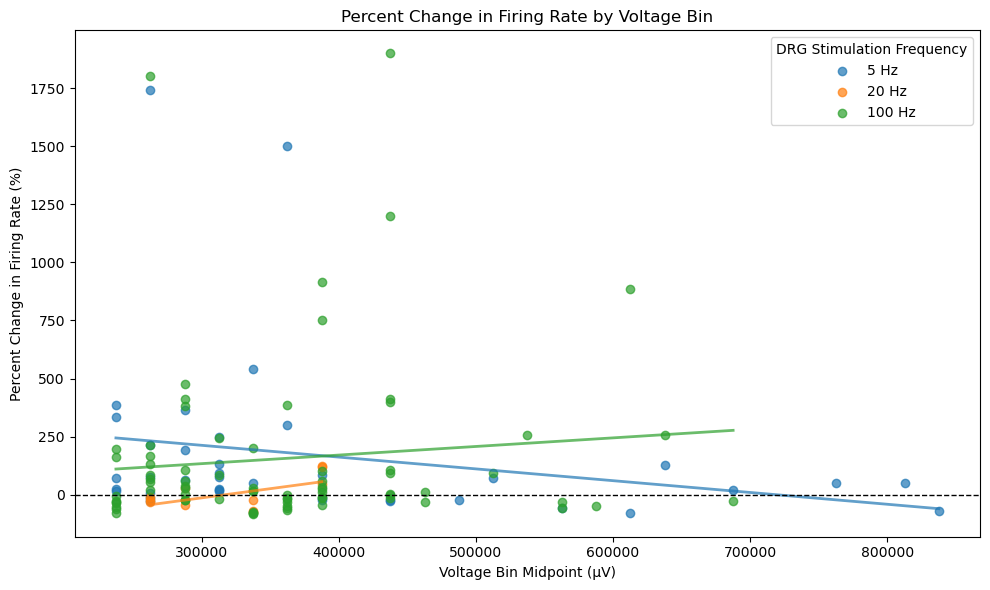

In [102]:
# Define the folder path containing your trial files.
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\tables"

# rat_qst_notes = pd.read_excel("path_to_rat_qst_notes.xlsx", index_col=0)

# Process all trials and aggregate the data.
aggregated_df_DW327 = aggregate_trials(folder_path, DW327.qst_trial_notes, bin_size=25000, correlation_threshold=0.3)

# Plot the aggregated percent change vs. voltage bin midpoints.
plot_percent_change(aggregated_df_DW327)


In [103]:
aggregated_df_DW327.sort_values(by=['percent_change'])

group,voltage_mid,neuron,post-stim,pre-stim,percent_change,trial,freq_hz
54,337500.5,15,17.421603,96.000000,-81.852497,VF_3_241125_154841,100
56,337500.5,20,3.484321,18.000000,-80.642664,VF_3_241125_154841,100
6,612500.5,13,2.732240,14.000000,-80.483997,VF_10_241125_162725,5
52,337500.5,8,6.968641,32.000000,-78.222997,VF_3_241125_154841,100
32,237500.5,19,4.000000,17.839445,-77.577778,VF_3_241125_154841,100
...,...,...,...,...,...,...,...
75,437500.5,12,25.996093,2.000000,1199.804635,VF_3_241125_154841,100
20,362500.5,17,32.000000,2.000000,1500.000000,VF_1_241125_153746,5
88,262500.5,18,91.000000,4.936646,1743.356667,VF_4_241125_155417,5
39,262500.5,16,57.000000,3.000000,1800.000000,VF_3_241125_154841,100


## analysis - DW323

Trial VF_1_240911_164342 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.
Trial VF_2_240911_165039 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.
Trial VF_3_240911_165617 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.
Trial VF_4_240911_170446 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.
Trial VF_7_240911_180931 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.


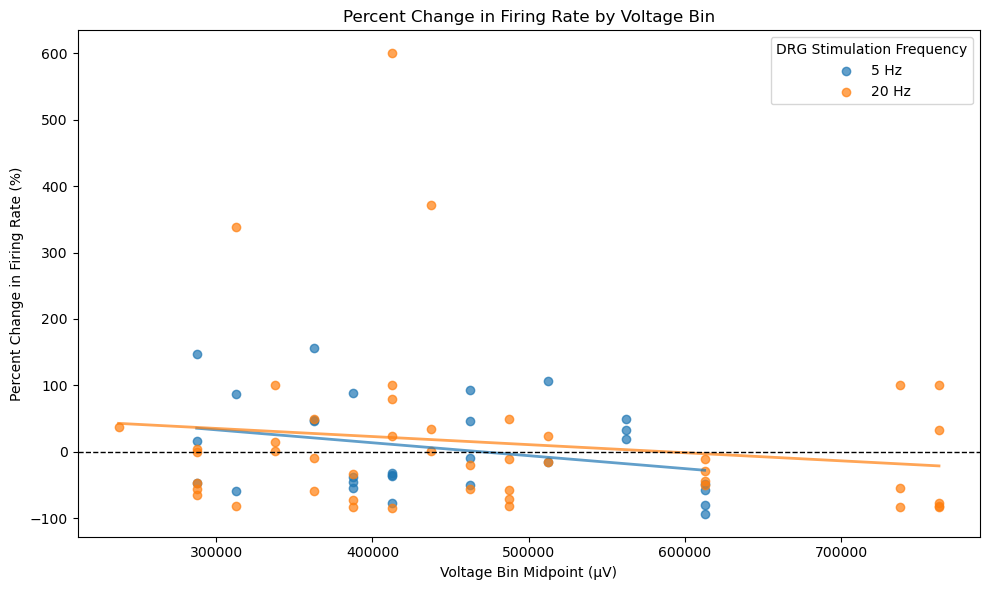

In [104]:
# Define the folder path containing your trial files.
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW323\tables"

# rat_qst_notes = pd.read_excel("path_to_rat_qst_notes.xlsx", index_col=0)

# Process all trials and aggregate the data.
aggregated_df_DW323 = aggregate_trials(folder_path, DW323.qst_trial_notes, bin_size=25000, correlation_threshold=0.3)

# Plot the aggregated percent change vs. voltage bin midpoints.
plot_percent_change(aggregated_df_DW323)


In [105]:
aggregated_df_DW323.sort_values(by=['percent_change'], ascending=False)

group,voltage_mid,neuron,post-stim,pre-stim,percent_change,trial,freq_hz
46,412500.5,0,14.000000,2.000000,600.000000,VF_6_240911_171505,20
52,437500.5,12,14.000000,2.963841,372.360000,VF_6_240911_171505,20
36,312500.5,14,11.784689,2.688654,338.311866,VF_6_240911_171505,20
7,362500.5,13,41.000000,16.000000,156.250000,VF_5_240911_171014,5
1,287500.5,11,32.000000,12.903843,147.988130,VF_5_240911_171014,5
...,...,...,...,...,...,...,...
67,737500.5,0,2.000000,12.000000,-83.333333,VF_6_240911_171505,20
70,762500.5,0,2.000000,12.000000,-83.333333,VF_6_240911_171505,20
43,387500.5,0,2.000000,12.000000,-83.333333,VF_6_240911_171505,20
49,412500.5,12,3.695418,24.000000,-84.602426,VF_6_240911_171505,20


## analysis - DW322

Trial VF_1_240918_143256 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.
Trial VF_3_240918_144658 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.
Trial VF_4_240918_145638 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.
Trial VF_5_240918_150137 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.
Trial VF_9_240918_152753 missing expected group columns. Found columns: ['voltage_mid', 'neuron']. Skipping trial.


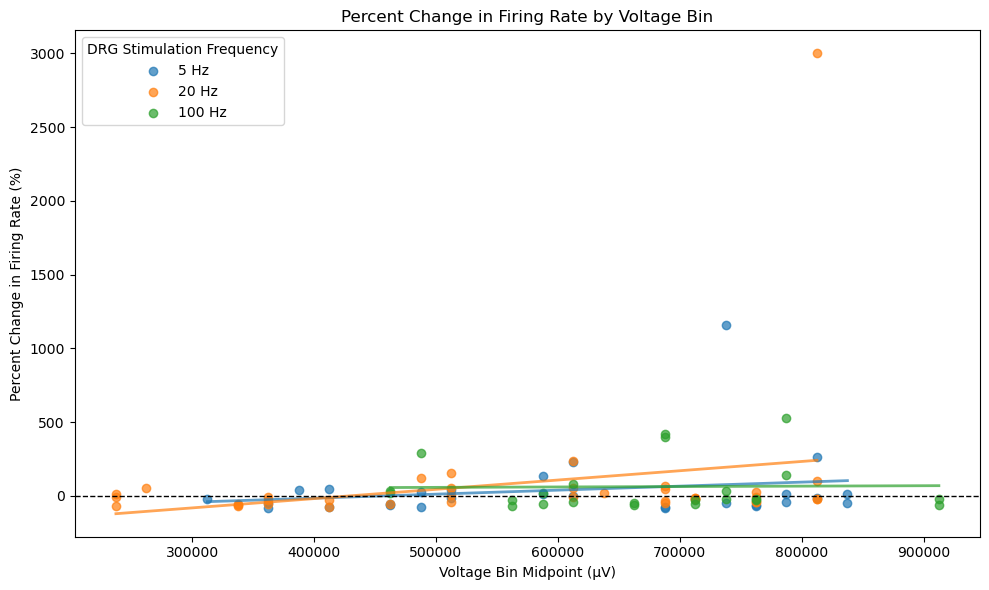

In [114]:
# Define the folder path containing your trial files.
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW322\tables"

# rat_qst_notes = pd.read_excel("path_to_rat_qst_notes.xlsx", index_col=0)

# Process all trials and aggregate the data.
aggregated_df_DW322 = aggregate_trials(folder_path, DW322.qst_trial_notes, bin_size=25000, correlation_threshold=.5)

# Plot the aggregated percent change vs. voltage bin midpoints.
plot_percent_change(aggregated_df_DW322)


In [115]:
aggregated_df_DW322.sort_values(by=['percent_change'], ascending=False) 

group,voltage_mid,neuron,post-stim,pre-stim,percent_change,trial,freq_hz
37,812500.5,24,62.000000,2.000000,3000.000000,VF_6_240918_150811,20
56,737500.5,24,31.333333,2.486915,1159.927721,VF_7_240918_151516,5
85,787500.5,23,88.000000,14.000000,528.571429,VF_8_240918_152056,100
77,687500.5,23,31.000000,5.971338,419.146667,VF_8_240918_152056,100
78,687500.5,25,15.000000,2.985669,402.400000,VF_8_240918_152056,100
...,...,...,...,...,...,...,...
19,412500.5,23,5.989817,22.000000,-72.773558,VF_6_240918_150811,20
55,687500.5,28,8.000000,34.000000,-76.470588,VF_7_240918_151516,5
47,487500.5,28,15.442671,70.000000,-77.939042,VF_7_240918_151516,5
54,687500.5,24,4.000000,20.000000,-80.000000,VF_7_240918_151516,5
